In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Audio
from matplotlib import rcParams

In [2]:
rcParams.update({'legend.fontsize': 'x-large',
                 'axes.labelsize': 'x-large',
                 'axes.titlesize':'x-large',
                 'xtick.labelsize':'x-large',
                 'ytick.labelsize':'x-large'})

# P4 - Adaptive Interference Cancellation

Implement the hands-free system discussed during the theoretical part of this exercise. Investigate the usage of a fixed stepsize and a power-dependent stepsize and compare both versions. Determine the the highest stable stepsize in both cases.

In [3]:
def truncate(signal, block_shift):
    """Truncate signal to multiple of block shift."""
    excess_samples = len(signal) % block_shift
    signal = signal[:-excess_samples]
    return signal

In [4]:
def plot_audio(signal):
    figure, axis = plt.subplots(1, 1, figsize=(12, 4))
    axis.plot(signal)
    axis.set_xlabel('Sample')
    axis.set_ylabel('Amplitude')
    plt.show()

In [5]:
# You can try different filter sizes.
# For efficient implementation always choose a power of 2!
filter_size = 2048
block_shift = filter_size
block_size = 2 * filter_size

In [6]:
# Music (mono) played back by the home server
music = np.fromfile('music_44_1_kHz.raw', dtype=np.float32)
music = truncate(music, block_shift)

In [7]:
# Read the true rir (length 4096) to calculate the mismatch
rir = np.fromfile('air1.dat', dtype=np.int16).astype(np.float)[:2048]
rir_for_comparison = rir[:filter_size]
scale_factor = np.max(rir_for_comparison)
rir = rir / scale_factor
rir_for_comparison = rir_for_comparison / scale_factor

In [8]:
# Microphone signal for a room-impulse-response of length 2048
mic = np.fromfile('mic_rir_2048.raw', dtype=np.float32)
mic = truncate(mic, block_shift)

In [9]:
# Total number of processing blocks, the first block will be half-valid
blocks = len(mic) // block_shift

In [10]:
# Simulated VAD
john_start_index = 1199782 // block_shift - 1;
john_stop_index = (1199782 + 129024) // block_shift + 1;
john_is_speaking = np.zeros((blocks,))
john_is_speaking[john_start_index:john_stop_index] = 1

## Music (mono) played back by the home server:

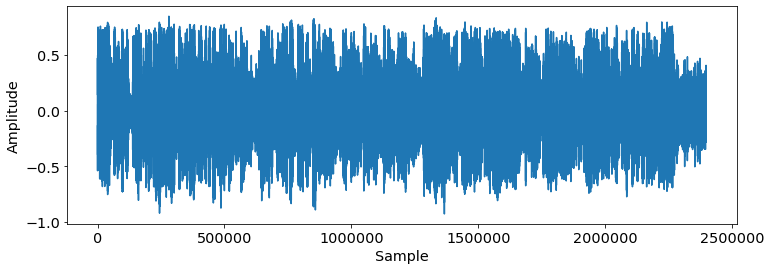

In [11]:
# If you get the error message `IOPub data rate exceeded.` start the Jupyter server with
# `jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000` or just play a
# downsampled version of the background music.
downsample_factor = 4
display(Audio(music[::downsample_factor], rate=44100 / downsample_factor))
plot_audio(music)

## Microphone signal for a room-impulse-response of length 2048

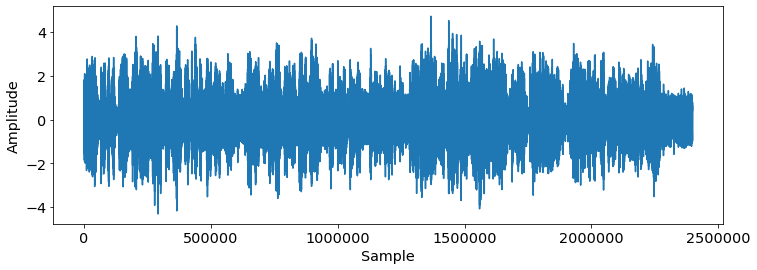

In [12]:
# If you get the error message `IOPub data rate exceeded.` start the Jupyter server with
# `jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000` or just play a
# downsampled version of the microphone signal.
downsample_factor = 4
display(Audio(mic[::downsample_factor], rate=44100 / downsample_factor))
plot_audio(mic)

## Room impulse response (RIR):

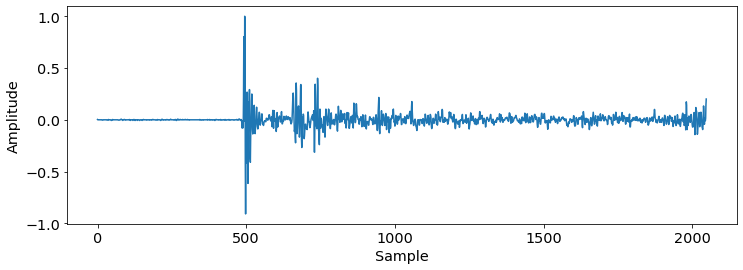

In [13]:
plot_audio(rir)

We here use the implementation of http://users.isy.liu.se/en/rt/fredrik/spcourse/multirate.pdf with additional frequency dependent step-size adaptation.

In [14]:
# Smooth factor for energy calculation
beta = 0.5

# Step size
power_dependent = True
if power_dependent:
    step_size = 1.0
else:
    step_size = 0.00001

# Allocate memory for the complex conjugated filter coefficients in frequency domain
W_conj = np.zeros(block_size, dtype=np.complex)

# Allocate memory for the concatenated blocks
concat_blocks = np.zeros(block_size)

# Allocate memory for the current power estimate per frequency bin
power = np.zeros(block_size)

# Allocate memory for the output
output = np.zeros_like(mic)

# Coefficient mismatch
mismatch = np.zeros(blocks)

# ERLE measure
erle = np.zeros(blocks)

for block_index in range(blocks):
    # Concatenation of old and new block of observations
    new_block = music[block_index*block_shift:(block_index+1)*block_shift]
    concat_blocks = np.concatenate([concat_blocks[block_shift:], new_block])
    
    # Convolution in frequency domain
    X = np.fft.fft(concat_blocks)
    Y_cyc = X * W_conj
    y_cyc = np.real(np.fft.ifft(Y_cyc))
    y = y_cyc[block_shift:]
    
    # Correlation in frequency domain
    e = mic[block_index*block_shift:(block_index+1)*block_shift] - y
    e_padded = np.pad(e, ((block_shift, 0)), mode='constant')
    E = np.fft.fft(e_padded)
    X_conj = X.conj()
    Gradient_conj = X_conj * E
    
    # Power dependent step size
    if power_dependent:
        power = (1 - beta) * power + beta * X * X_conj
        inverse_power = 1 / (power + 1e-6)
        Gradient_conj *= inverse_power
    
    # Filter update using the voice activity information
    if not john_is_speaking[block_index]:
        W_conj += step_size * Gradient_conj
        # Gradient constraint
        grad_constraint = np.real(np.fft.ifft(W_conj))
        w_conj = grad_constraint[:block_shift] 
        w_conj_padded = np.pad(w_conj, ((0, block_shift)), mode='constant')
        W_conj = np.fft.fft(w_conj_padded)
    
    # Summaries
    erle[block_index] = (
        np.sum(np.abs(mic[block_index*block_shift:(block_index+1)*block_shift]) ** 2)
        / np.sum(np.abs(e) ** 2)
    )
    w = w_conj # Coefficients are real valued
    mismatch[block_index] = np.sum(np.abs(rir_for_comparison - w) ** 2)
    output[block_index*block_shift:(block_index+1)*block_shift] = e

## Output of the adaptive filter:

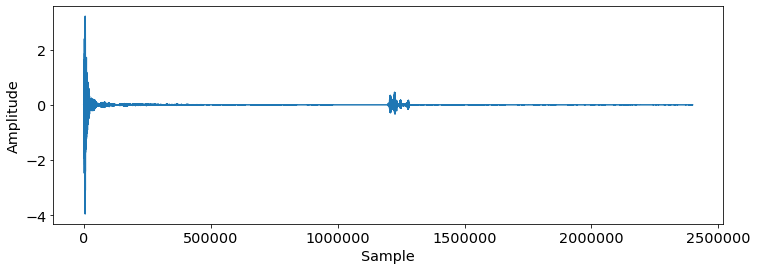

In [15]:
# If you get the error message `IOPub data rate exceeded.` start the Jupyter server with
# `jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000` or just play a
# downsampled version of the output signal of the adaptive filter.
downsample_factor = 4
display(Audio(output[::downsample_factor], rate=44100 / downsample_factor))
plot_audio(output)

Display the development of the length of the error-vector(filter coefficients - coefficients ofthe room-impulse-response).

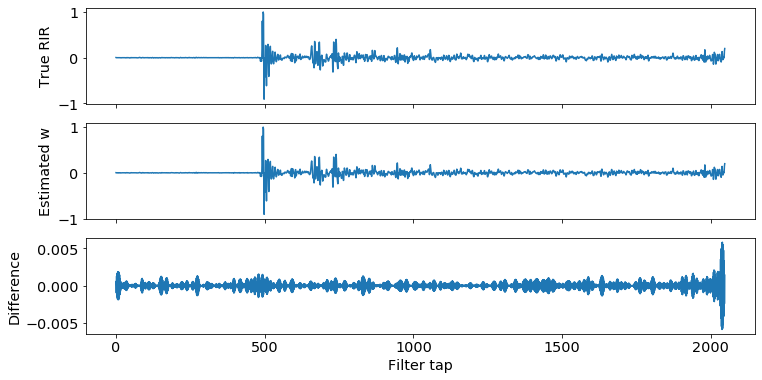

In [16]:
figure, axes = plt.subplots(3, 1, figsize=(12, 6), squeeze=False, sharex=True)
ax = axes[0, 0]
ax.plot(rir)
ax.set_ylabel('True RIR')

ax = axes[1, 0]
ax.plot(w)
ax.set_ylabel('Estimated w')

ax = axes[2, 0]
ax.plot(rir - w.flatten())
ax.set_xlabel('Filter tap')
ax.set_ylabel('Difference')
plt.show()

Display the development of $ERLE_{dB}(m)=10 \log
\frac{\|\mathbf{d}(mN)\|^2}{\|\mathbf{e}(mN)\|^2}\text{ dB}$.

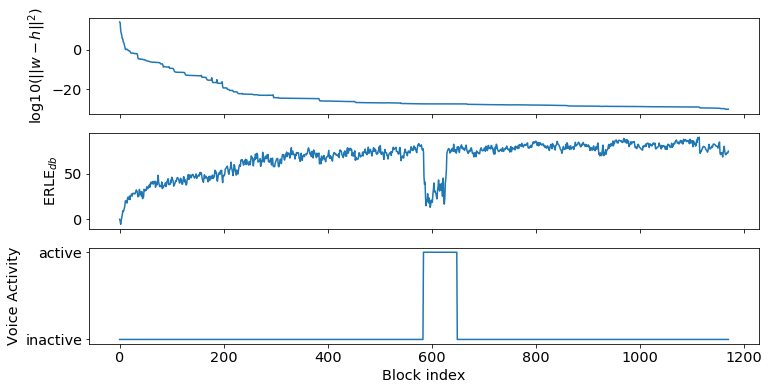

In [17]:
figure, axes = plt.subplots(3, 1, figsize=(12, 6), squeeze=False, sharex=True)
ax = axes[0, 0]
ax.plot(10 * np.log10(mismatch))
ax.set_ylabel('$\log10(||w - h||^2)$')

ax = axes[1, 0]
ax.plot(10 * np.log10(erle))
ax.set_ylabel('ERLE$_{db}$')

ax = axes[2, 0]
ax.plot(john_is_speaking)
ax.set_xlabel('Block index')
plt.sca(axes[2, 0])
plt.yticks(range(2), ['inactive', 'active'])
ax.set_ylabel('Voice Activity')
plt.show()